## Method 3: Model improvements  


- **Balanced Sampling:** Introduced `WeightedRandomSampler` to handle class imbalance during training.
- **Regularisation:** Applied `weight_decay` in the optimizer to reduce overfitting via L2 regularisation.
- **Validation Split:** Added a validation set to monitor generalisation and prevent overfitting.
- **Early Stopping:** Implemented early stopping based on validation loss to avoid over-training.
- **Learning Rate Scheduling:** Used `ReduceLROnPlateau` to dynamically adjust learning rate when performance plateaus.



In [26]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Mode definition  

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, dropout=0.2):
        super(ResidualBlock1D, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ExpandedResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ExpandedResNet1D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        layers = [ResidualBlock1D(in_channels, out_channels, stride=stride, downsample=downsample)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return self.fc(x)


### Load full data and compute class weights

In [18]:
X_all = np.load("models/v2/X_all.npy")
y_all = np.load("models/v2/y_all.npy")
y_labels = np.load("models/v2/y_labels.npy", allow_pickle=True)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_all), y=y_all)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("Class weights:", class_weights)


Class weights: [1. 1. 1.]


### Train/Validation/Test Split & Tensors

In [27]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

X_train_tensor = torch.tensor(X_train).unsqueeze(1).float()
y_train_tensor = torch.tensor(y_train).long()

X_val_tensor = torch.tensor(X_val).unsqueeze(1).float()
y_val_tensor = torch.tensor(y_val).long()

X_test_tensor = torch.tensor(X_test).unsqueeze(1).float()
y_test_tensor = torch.tensor(y_test).long()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)


### Optional Noise Augmentation

In [28]:
def add_noise(inputs, noise_level=0.01):
    noise = torch.randn_like(inputs) * noise_level
    return inputs + noise

### Focal Loss

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

### Model & Loss Function with Class Weights

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ExpandedResNet1D(input_channels=1, num_classes=len(y_labels)).to(device)
criterion = FocalLoss(alpha=class_weights_tensor.to(device), gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

### Training Loop

In [32]:
num_epochs = 25  # or increase if you like

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_preds, train_targets = [], []

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xb, yb = xb.to(device), yb.to(device)
        xb = add_noise(xb, noise_level=0.01)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_targets.extend(yb.cpu().numpy())

    scheduler.step()
    train_acc = accuracy_score(train_targets, train_preds)
    avg_train_loss = np.mean(train_losses)

    # Validation
    model.eval()


Epoch 25/25: 100%|██████████| 24/24 [00:02<00:00,  9.79it/s]


### Evaluation on Test Set


🎯 Test Accuracy: 0.9979

🧾 Classification Report:
              precision    recall  f1-score   support

      inward       1.00      0.99      1.00       156
    occluded       0.99      1.00      1.00       156
     outward       1.00      1.00      1.00       157

    accuracy                           1.00       469
   macro avg       1.00      1.00      1.00       469
weighted avg       1.00      1.00      1.00       469



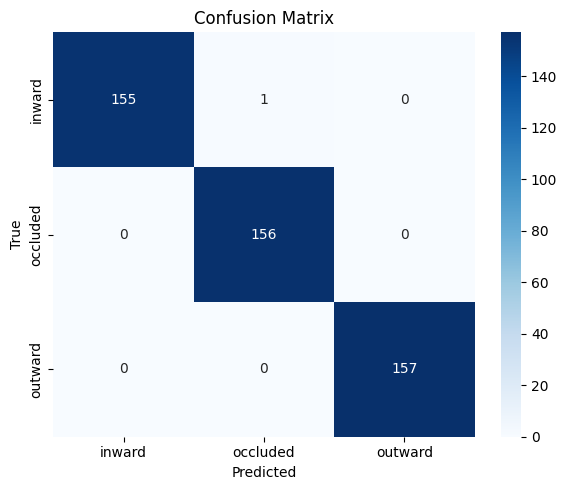

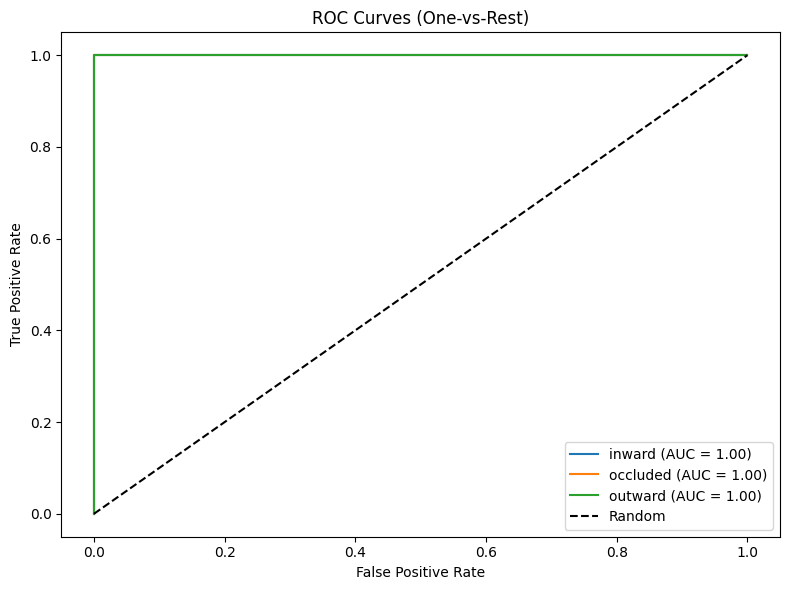

In [ ]:
model.load_state_dict(torch.load("models/v2/resnet1d_final.pt"))
model.eval()
test_preds, test_targets, test_probs = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        test_preds.extend(preds)
        test_targets.extend(yb.numpy())
        test_probs.extend(probs)

test_preds = np.array(test_preds)
test_targets = np.array(test_targets)
test_probs = np.array(test_probs)

acc = accuracy_score(test_targets, test_preds)
print(f"\n🎯 Test Accuracy: {acc:.4f}")

print("\n🧾 Classification Report:")
print(classification_report(test_targets, test_preds, target_names=y_labels))

cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=y_labels, yticklabels=y_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC
y_test_bin = label_binarize(test_targets, classes=np.arange(len(y_labels)))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8, 6))
for i in range(len(y_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{y_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.show()
